<a href="https://colab.research.google.com/github/sunlaito/XmonCoupler/blob/master/RXR_Hm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

RXR Hamiltonian

In [ ]:
!pip install qutip

Part 1: Define functions

In [ ]:
from qutip import *
import numpy as np
import scipy.special as sp
import scipy.integrate as si
import matplotlib.pyplot as plt

# Function Even check
def EvenQ(number):
        return number % 2 == 0


# Function En/Ec of Level n
def EnXm(n,rJC):
  if EvenQ(n):
    return sp.mathieu_a(n,-rJC/2)-sp.mathieu_a(0,-rJC/2)
  else:
    return sp.mathieu_b(n+1,-rJC/2)-sp.mathieu_a(0,-rJC/2)


# Function Psi(phi) of Level n
def PsiN(n,rJC,phi):
  Rrad=180/np.pi;
  if EvenQ(n):
    return sp.mathieu_cem(n,-rJC/2,phi*Rrad/2)[0]/np.sqrt(np.pi)
  else:
    return sp.mathieu_sem(n+1,-rJC/2,phi*Rrad/2)[0]/np.sqrt(np.pi)
  #scipy mathieu function take phi(deg) as input, but still regard phi(rad) as its independent variable!!!
  # 1/np.sqrt(np.pi): normalization coefficient


# Function d_Psi(phi)/d_phi of Level n
def PsiNP(n,rJC,phi):
  Rrad=180/np.pi;
  if EvenQ(n):
    return sp.mathieu_cem(n,-rJC/2,phi*Rrad/2)[1]/np.sqrt(np.pi)/2
  else:
    return sp.mathieu_sem(n+1,-rJC/2,phi*Rrad/2)[1]/np.sqrt(np.pi)/2
 #scipy mathieu derivative function take phi(deg) as input, but still regard phi(rad) as its independent variable!!!


# Function Tij, Elements of the Transition Matrix of Xmon
def FTij(rJC,i,j):
  fphi=lambda phi:PsiN(i,rJC,phi) * PsiNP(j,rJC,phi)
  return si.quad(fphi,0,2*np.pi)[0]


# Function Transition Matrix of Xmon
def FXTmat(rJC):
  TList=np.array([FTij(rJC,0,1),FTij(rJC,1,2)])
  return qdiags(TList,1)+qdiags(-TList,-1)


# Function En/Ec Matrix of Xmon
def FXEmat(rJC):
  return qdiags([0,EnXm(1,rJC),EnXm(2,rJC)],0)


# Function Total Hm of System
def HTotal(rJC):
  Tmat=FXTmat(rJC)
  return (GpEa*HaM+GpEb*HbM+GpEm*HmM+tensor(IC3,GpEcx*FXEmat(rJC))
  +GpEab*HabM +GpEam*HamM +GpEbm*HbmM
  +GpExa*tensor(QII,Tmat)+GpExb*tensor(IQI,Tmat)+GpExm*tensor(IIQ,Tmat))
  # return only recognizes the first line of the above expression if () is not used


# Function First N eigenenergies of HTotal
def EnHt(rJC,N):
  return HTotal(rJC).eigenenergies(eigvals=N)


# Function First N eigenenergies of HTotal for Array rJCV
def EnHtV(rJCV,N):
  EnHtV=np.zeros(N)
  for rJC in rJCV:
    EnHtV=np.vstack((EnHtV,EnHt(rJC,N)))
  return np.delete(EnHtV,0,0)


# Function states probility for eigenmodes of Ra & Rb
def EnRab(rJC):
  pArray=np.array([0,0,0,0],dtype = "complex_")
  EigenV=HTotal(rJC).eigenstates(eigvals=3)[1]
  
  # EigenV[0]: ground state of the system
  # EigenV[1]: eigenmode with the lower energy
  pArray[0]=EigenV[1][stRaRow,0] #stRaRow=48
  pArray[1]=EigenV[1][stRbRow,0] #stRbRow=12
  
  # EigenV[2]: eigenmode with the higher energy
  pArray[2]=EigenV[2][stRaRow,0] 
  pArray[3]=EigenV[2][stRaRow,0]
  return abs(pArray)**2


# Function states probility for eigenmodes of Ra & Rb for vector rJCV
def EnRabV(rJCV):
  pVMat=np.zeros(4)
  for rJC in rJCV:
    pVMat=np.vstack((pVMat,EnRab(rJC)))
  return np.delete(pVMat,0,0)


# Function derive rJC and flux from a certain f01, Ec, and rJCmax
def FrJC(f01,Ec,rJCmax):
  rJC=(Ec+f01)**2/8/Ec**2;
  flux=np.arccos(rJC/rJCmax);
  return [rJC,flux]


# Function derive f01 from a certain Ec and rJC
def Ff01(Ec,rJC):
  return np.sqrt(8*rJC)*Ec-Ec


# Resonator Parameters
NumC=4; #Resonator levels
aM=destroy(NumC)
adM=create(NumC)
qM=aM-adM
nM=num(NumC) # operator N
IC=qeye(NumC)
# Xmon Parameters
NumX=3; #Xmon levels
IX=qeye(NumX)
# Tensor Matrix
HaM=tensor(nM,IC,IC,IX)
HbM=tensor(IC, nM, IC, IX)
HmM=tensor(IC, IC, nM, IX)
IC3=tensor(IC, IC, IC)
QII=tensor(qM, IC, IC)
IQI=tensor(IC, qM, IC)
IIQ=tensor(IC, IC, qM)
HabM=tensor(qM, qM, IC, IX)
HamM=tensor(qM, IC, qM, IX)
HbmM=tensor(IC, qM, qM, IX)
# Resonator states
stRg=basis(NumC,0)
stRe=basis(NumC,1)
stXg=basis(NumX,0)
# Tensor resonator states
stRa= tensor(stRe,stRg,stRg,stXg)
stRb= tensor(stRg,stRe,stRg,stXg)
stRaRow=48 # stRa[stRaRow,0]=1
stRbRow=12 # stRb[stRbRow,0]=1

Part 2: Plot figures

In [ ]:
# Oringinal Parameters from MMA
# Ea!=Eb, Exa!=Exb
# Parameters from MMA (Rm considered)
rJCmax=195.53094314412937; 
GpEa=4.880856484706924e9;
GpEb=4.880601012712622e9; 
GpEm=5.555193967438693e9;
GpEcx=1.9449718343371117e8; 
GpEab=-982494.9644337803;
GpEam=-580242.8043396688; 
GpEbm=-882901.6518874831;
GpExa=-2.6774428090971626e7; 
GpExb=-2.6774716480690457e7;
GpExm=-2.1940666930725377e7;

NumEn=3
NumPoints=1000
FluxV=np.linspace(0,1,NumPoints+1)
rJCV=rJCmax*np.cos(FluxV);

In [ ]:
NumRab=4
FluxMat_Rab=np.tile(FluxV,(NumRab,1)).transpose()
pVMat_Rab=EnRabV(rJCV)

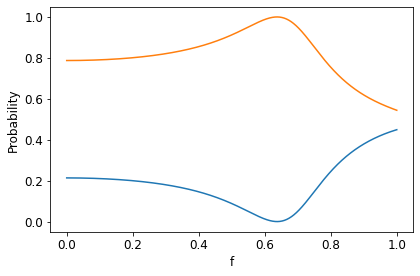

In [ ]:
plt.rcParams.update({'font.size': 12})
plt.rcParams.update({'figure.autolayout': True}) #avoid missing label in pdf file

plt.plot(FluxMat_Rab[:,0:2],pVMat_Rab[:,0:2])
plt.xlabel('f')
plt.ylabel('Probability')
plt.savefig('fig-pabM.pdf')
plt.show()

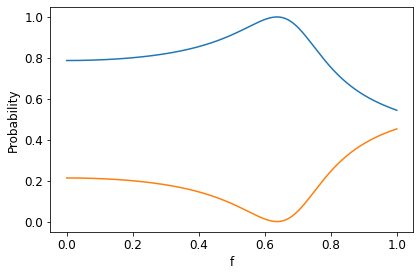

In [ ]:
plt.rcParams.update({'font.size': 12})
plt.rcParams.update({'figure.autolayout': True}) #avoid missing label in pdf file

plt.plot(FluxMat_Rab[:,2:4],pVMat_Rab[:,[1,3]])
plt.xlabel('f')
plt.ylabel('Probability')
plt.savefig('fig-pabP.pdf')
plt.show()

In [ ]:
FluxMat_to=np.tile(FluxV,(NumEn,1)).transpose()[:,1:3]
EnMat_to=EnHtV(rJCV,NumEn)[:,1:3]

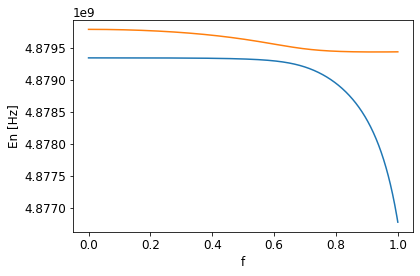

0.2553075386209488
637 0.637 6.6966034893544295 0.1276537693104744


In [ ]:
plt.rcParams.update({'font.size': 12})
plt.rcParams.update({'figure.autolayout': True}) #avoid missing label in pdf file

plt.plot(FluxMat_to,EnMat_to)
plt.xlabel('f')
plt.ylabel('En [Hz]')
plt.savefig('fig-En3.pdf')
plt.show()

EnDiff=np.abs(EnMat_to[:,0]-EnMat_to[:,1]);
EnDiffMin= np.amin(EnDiff)
IdMin = np.where(EnDiff == EnDiffMin)[0][0]


#turn-off frequency for Xmon
#minimum frequency difference between mormal modes of A&B, should equal to |fA-fB|
print(EnDiffMin/1e6)
print(IdMin,FluxV[IdMin],(EnXm(1,rJCV[IdMin])-EnXm(0,rJCV[IdMin]))*GpEcx/1e9,EnDiff[IdMin]/2/1e6)            

In [ ]:
# Function 
def Fgab(Dabd,Dpm):
  return np.sqrt(Dpm**2-Dab**2)/2

# Function 
def FdeltaS(freqX):
  deltaS= GpExa**2*(1/(GpEa-freqX)-1/(GpEa+freqX)) -GpExb**2*(1/(GpEb-freqX)-1/(GpEb+freqX))
  return deltaS 

In [ ]:
Dab=GpEa-GpEb
Dab

255471.99430274963

In [ ]:
IdTest=637
fXmon=(EnXm(1,rJCV[IdTest])-EnXm(0,rJCV[IdTest]))*GpEcx;
#fXmon = Ff01(GpEcx,rJCV[IdTest])
Dpm=EnDiff[IdTest]

deltaS=FdeltaS(fXmon)
gab=Fgab(Dab+deltaS,Dpm)

print(FluxV[IdTest],fXmon/1e9,Dpm)
print(deltaS)
print(Dab+deltaS)
print(gab)

0.637 6.6966034893544295 255307.5386209488
-44.33663758588955
255427.65766516374
nan


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in sqrt
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
IdTest=0
fXmon=(EnXm(1,rJCV[IdTest])-EnXm(0,rJCV[IdTest]))*GpEcx;
#fXmon = Ff01(GpEcx,rJCV[IdTest])
Dpm=EnDiff[IdTest]
deltaS=FdeltaS(fXmon)
gab=Fgab(Dab+deltaS,Dpm)

print(FluxV[IdTest],fXmon/1e9,Dpm)
print(deltaS)
print(Dab+deltaS)
print(gab)

0.0 7.492699451176647 445490.0185585022
-18.487586554081645
255453.50671619555
182479.73638340677


In [ ]:
IdTest=700
fXmon=(EnXm(1,rJCV[IdTest])-EnXm(0,rJCV[IdTest]))*GpEcx;
#fXmon = Ff01(GpEcx,rJCV[IdTest])
Dpm=EnDiff[IdTest]
deltaS=FdeltaS(fXmon)
gab=Fgab(Dab+deltaS,Dpm)

print(FluxV[IdTest],fXmon/1e9,Dpm)
print(deltaS)
print(Dab+deltaS)
print(gab)

0.7000000000000001 6.526874896927784 283708.4479675293
-55.442790913337376
255416.5515118363
61693.88862586013


In [ ]:
IdTest=800
fXmon=(EnXm(1,rJCV[IdTest])-EnXm(0,rJCV[IdTest]))*GpEcx;
#fXmon = Ff01(GpEcx,rJCV[IdTest])
Dpm=EnDiff[IdTest]
deltaS=FdeltaS(fXmon)
gab=Fgab(Dab+deltaS,Dpm)

print(FluxV[IdTest],fXmon/1e9,Dpm)
print(deltaS)
print(Dab+deltaS)
print(gab)

0.8 6.21991156598028 500523.5490875244
-87.71038182056509
255384.28392092907
215207.97111059068


In [ ]:
IdTest=900
fXmon=(EnXm(1,rJCV[IdTest])-EnXm(0,rJCV[IdTest]))*GpEcx;
#fXmon = Ff01(GpEcx,rJCV[IdTest])
Dpm=EnDiff[IdTest]
deltaS=FdeltaS(fXmon)
gab=Fgab(Dab+deltaS,Dpm)

print(FluxV[IdTest],fXmon/1e9,Dpm)
print(deltaS)
print(Dab+deltaS)
print(gab/1e6)

0.9 5.863588737057793 1060987.2850551605
-170.84936410258524
255301.14493864705
0.5148854433696141


In [ ]:
IdTest=850
fXmon=(EnXm(1,rJCV[IdTest])-EnXm(0,rJCV[IdTest]))*GpEcx;
#fXmon = Ff01(GpEcx,rJCV[IdTest])
Dpm=EnDiff[IdTest]
deltaS=FdeltaS(fXmon)
gab=Fgab(Dab+deltaS,Dpm)

print(FluxV[IdTest],fXmon/1e9,Dpm/1e6)
print(deltaS)
print(Dab+deltaS)
print(gab/1e6)


0.85 6.048206149394899 0.7201393771152497
-118.19258475268725
255353.80171799695
0.3366507027316725


In [ ]:
IdTest=1000
fXmon=(EnXm(1,rJCV[IdTest])-EnXm(0,rJCV[IdTest]))*GpEcx;
#fXmon = Ff01(GpEcx,rJCV[IdTest])
Dpm=EnDiff[IdTest]
deltaS=FdeltaS(fXmon)
gab=Fgab(Dab+deltaS,Dpm)

print(FluxV[IdTest],fXmon/1e9,Dpm)
print(deltaS)
print(Dab+deltaS)
print(gab/1e6)


1.0 5.452492732013895 2660556.168434143
-529.9959566527978
254941.99834609684
1.3241311477266842


In [ ]:
# Results from MMA with ignoring Cam and Cbm. In this case ExA=ExB, Exa=Exb
rJCmax=195.53094294845417; 
GpEa=4.886646940774334e9;
GpEb=4.886646940774334e9; 
GpEm=5.5574257954247055e9;
GpEcx=1.944971836283518e8; 
GpEab=-983673.5173940662;
GpEam=-377756.9677136507; 
GpEbm=-377756.9677136507;
GpExa=-2.678964318946407e7; 
GpExb=-2.678964318946407e7;
GpExm=-2.194061811026641e7

NumEn=3
NumPoints=1000
FluxV=np.linspace(0,1,NumPoints+1)  #devide interval into NumPoints parts, resulting (NumPoints+1) points
rJCV=rJCmax*np.cos(FluxV);

FluxMat_toNM=np.tile(FluxV,(NumEn,1)).transpose()[:,1:3]
EnMat_toNM=EnHtV(rJCV,NumEn)[:,1:3]

In [ ]:
IdTest=0
print(FluxV[IdTest],(EnXm(1,rJCV[IdTest])-EnXm(0,rJCV[IdTest]))*GpEcx/1e9,EnDiff[IdTest]/2/1e6)

0.0 7.4926994548229535 0.18116261705493927


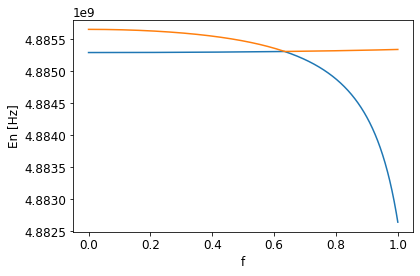

634 0.634 6.70424545131946 8.490963363647461e-05


In [ ]:
plt.rcParams.update({'font.size': 12})
plt.rcParams.update({'figure.autolayout': True}) #avoid missing label in pdf file

plt.plot(FluxMat_toNM,EnMat_toNM)
plt.xlabel('f')
plt.ylabel('En [Hz]')
plt.savefig('fig-En4.pdf')
plt.show()

EnDiff=np.abs(EnMat_toNM[:,0]-EnMat_toNM[:,1]);
EnDiffMin= np.amin(EnDiff)
IdMin = np.where(EnDiff == EnDiffMin)[0][0]

print(IdMin,FluxV[IdMin],(EnXm(1,rJCV[IdMin])-EnXm(0,rJCV[IdMin]))*GpEcx/1e9,EnDiff[IdMin]/2/1e6) 

In [ ]:
IdTest=0
print(FluxV[IdTest],(EnXm(1,rJCV[IdTest])-EnXm(0,rJCV[IdTest]))*GpEcx/1e9,EnDiff[IdTest]/2/1e6)

0.0 7.4926994548229535 0.18116261705493927


In [ ]:
IdTest=0
print(FluxV[IdTest],(EnXm(1,rJCV[IdTest])-EnXm(0,rJCV[IdTest]))*GpEcx/1e9,EnDiff[IdTest]/2/1e6)

0.0 7.4926994548229535 0.18116261705493927


In [ ]:
IdTest=700
print(FluxV[IdTest],(EnXm(1,rJCV[IdTest])-EnXm(0,rJCV[IdTest]))*GpEcx/1e9,EnDiff[IdTest]/2/1e6)

0.7000000000000001 6.526874900089932 0.14185422398376465


In [ ]:
IdTest=800
print(FluxV[IdTest],(EnXm(1,rJCV[IdTest])-EnXm(0,rJCV[IdTest]))*GpEcx/1e9,EnDiff[IdTest]/2/1e6)

0.8 6.2199115689884845 0.2502617745437622


In [ ]:
IdTest=900
print(FluxV[IdTest],(EnXm(1,rJCV[IdTest])-EnXm(0,rJCV[IdTest]))*GpEcx/1e9,EnDiff[IdTest]/2/1e6)

0.9 5.863588739887248 0.5304936425275802


In [ ]:
IdTest=1000
print(FluxV[IdTest],(EnXm(1,rJCV[IdTest])-EnXm(0,rJCV[IdTest]))*GpEcx/1e9,EnDiff[IdTest]/2/1e6)

1.0 5.452492734637043 1.3302780842170716


In [ ]:
sa=basis(2,0)
sb=basis(2,0)
s00=tensor(sa,sb)
print(s00)

Quantum object: dims = [[2, 2], [1, 1]], shape = (4, 1), type = ket
Qobj data =
[[1.]
 [0.]
 [0.]
 [0.]]


In [ ]:
ma=Qobj([[1,0],[0,1]])
mb=Qobj([[0,2],[2,0]])
mtest=tensor(ma,mb)
print(mtest)

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[0. 2. 0. 0.]
 [2. 0. 0. 0.]
 [0. 0. 0. 2.]
 [0. 0. 2. 0.]]


In [ ]:
print(mtest.eigenenergies())

[-2. -2.  2.  2.]


In [ ]:
print(mtest.eigenstates())

(array([-2., -2.,  2.,  2.]), array([Quantum object: dims = [[2, 2], [1, 1]], shape = (4, 1), type = ket
Qobj data =
[[ 0.70710678]
 [-0.70710678]
 [ 0.        ]
 [ 0.        ]],
       Quantum object: dims = [[2, 2], [1, 1]], shape = (4, 1), type = ket
Qobj data =
[[ 0.        ]
 [ 0.        ]
 [ 0.70710678]
 [-0.70710678]],
       Quantum object: dims = [[2, 2], [1, 1]], shape = (4, 1), type = ket
Qobj data =
[[0.70710678]
 [0.70710678]
 [0.        ]
 [0.        ]],
       Quantum object: dims = [[2, 2], [1, 1]], shape = (4, 1), type = ket
Qobj data =
[[0.        ]
 [0.        ]
 [0.70710678]
 [0.70710678]]], dtype=object))


In [ ]:
eTest=mtest.eigenstates()[1][0]
print(eTest)

Quantum object: dims = [[2, 2], [1, 1]], shape = (4, 1), type = ket
Qobj data =
[[ 0.70710678]
 [-0.70710678]
 [ 0.        ]
 [ 0.        ]]


In [ ]:
mtest.eigenstates(eigvals=3)

(array([-2., -2.,  2.]),
 array([Quantum object: dims = [[2, 2], [1, 1]], shape = (4, 1), type = ket
 Qobj data =
 [[-0.70710678]
  [ 0.70710678]
  [ 0.        ]
  [ 0.        ]],
        Quantum object: dims = [[2, 2], [1, 1]], shape = (4, 1), type = ket
 Qobj data =
 [[ 0.        ]
  [ 0.        ]
  [-0.70710678]
  [ 0.70710678]],
        Quantum object: dims = [[2, 2], [1, 1]], shape = (4, 1), type = ket
 Qobj data =
 [[0.        ]
  [0.        ]
  [0.70710678]
  [0.70710678]]], dtype=object))